#  Проект: Прогнозирование заказов такси

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [72]:
#импортируем библиотеки 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

import time
import warnings
warnings.filterwarnings('ignore')

In [73]:
#функция для чтения файла

def file_reader(path):
    df = pd.read_csv(path, index_col=[0], parse_dates=[0])
    print('=======================================')
    print('Первые пять строк:')
    print('=======================================')
    display(df.head(5))
    print('=======================================')
    print('Общая информация по датасету:')
    print('=======================================')
    print(df.info())
    print('=======================================')
    print('Статистическая информация по датасету:')
    print('=======================================')
    display(df.describe())
    print('=======================================')
    print('Количество пропусков по столбцам:')
    print('=======================================')
    print(df.isna().sum())

    
    return df

In [74]:
df = file_reader("/datasets/taxi.csv")

Первые пять строк:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Общая информация по датасету:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
Статистическая информация по датасету:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество пропусков по столбцам:
num_orders    0
dtype: int64


In [75]:
print(df.index.is_monotonic)

True


In [76]:
print("Время начала данных: {0}, время конца данных: {1}".format(df.index.min(), df.index.max()))

Время начала данных: 2018-03-01 00:00:00, время конца данных: 2018-08-31 23:50:00


In [77]:
#функция построения графиков
def hist_builder(data_column, label, bins):
   
    sns.set(rc={"figure.figsize":(15, 15)}, font_scale=1)
    f, axes = plt.subplots(1, 2)
    
    
    (sns.distplot(data_column, bins=bins, ax=axes[0])
     .set(title='Плотность распределения целевого признака: {0}'.format(label),
          xlabel='Признак {0}'.format(label),
          ylabel='Плотность целевого признака {0}'.format(label)))

    (sns.boxplot(data_column, orient='h', ax=axes[1])
       .set(title='Boxplot для целевого признака {0}'.format(label),
        xlabel='Целевой ризнак {0}'.format(label)))
    plt.show()
#функция анализа аномалий
def anomaly_detection(data_column, label):
    anomaly_threshold_up = data_column.quantile(0.75) + (data_column.quantile(0.75) - data_column.quantile(0.25)) * 1.5
    anomaly_threshold_down = data_column.quantile(0.25) - (data_column.quantile(0.75) - data_column.quantile(0.25)) * 1.5
    anomaly_percent = round(len(data_column[(data_column > anomaly_threshold_up) | (data_column < anomaly_threshold_down)]) / len(data_column) * 100, 2)
    print("Доля выбросов параметра " + label + " равно: " + str(anomaly_percent) + "%")
    
#итоговая функция
def check_param(bins, data_column, column):
    print('=======================================')
    print("Анализ параметров датасета")
    print('=======================================')

    print('=======================================')
    print("Анализ параметра '" + column + "':")
    print('=======================================')
    hist_builder(data_column, column, bins)
    anomaly_detection(data_column, column)


Анализ параметров датасета
Анализ параметра 'Число заказов':


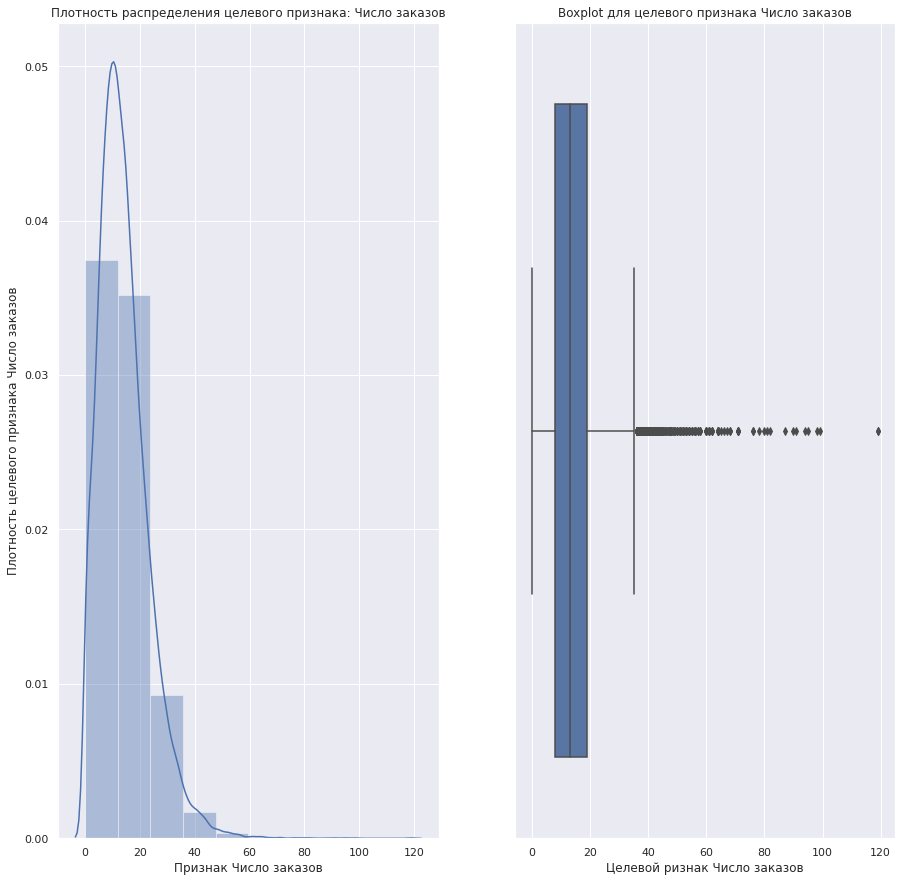

Доля выбросов параметра Число заказов равно: 2.59%


In [78]:
check_param(10, df['num_orders'], 'Число заказов')

**Вывод по пункту 1:**


- Провели общий осмотр данных, в датасете содержится 26496 наблюдений по единственному (целевому) признаку "число заказов". 
- Пропусков нет 
- Наблюдения расположены монотонно (временной индекс располагается в хронологическом порядке)
- Доля выбросов по целевому признаку 'Число заказов': 2.59%. Не будем удалять выбросы, их число невелико, но они будут полезны для будущего анализа.
- Данные скошены вправо (медиана 13 < среднее 14). Время начала данных: 2018-03-01 00:00:00, время конца данных: 2018-08-31 23:50:00. Минимальное число заказов:0, максимальное: 119

## Анализ

In [79]:
#ресемплируем данные по одному часу
#df = df.sort_index()
df = df.resample('1H').sum()

In [80]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Ресемплинг по одному часу прошел успешно

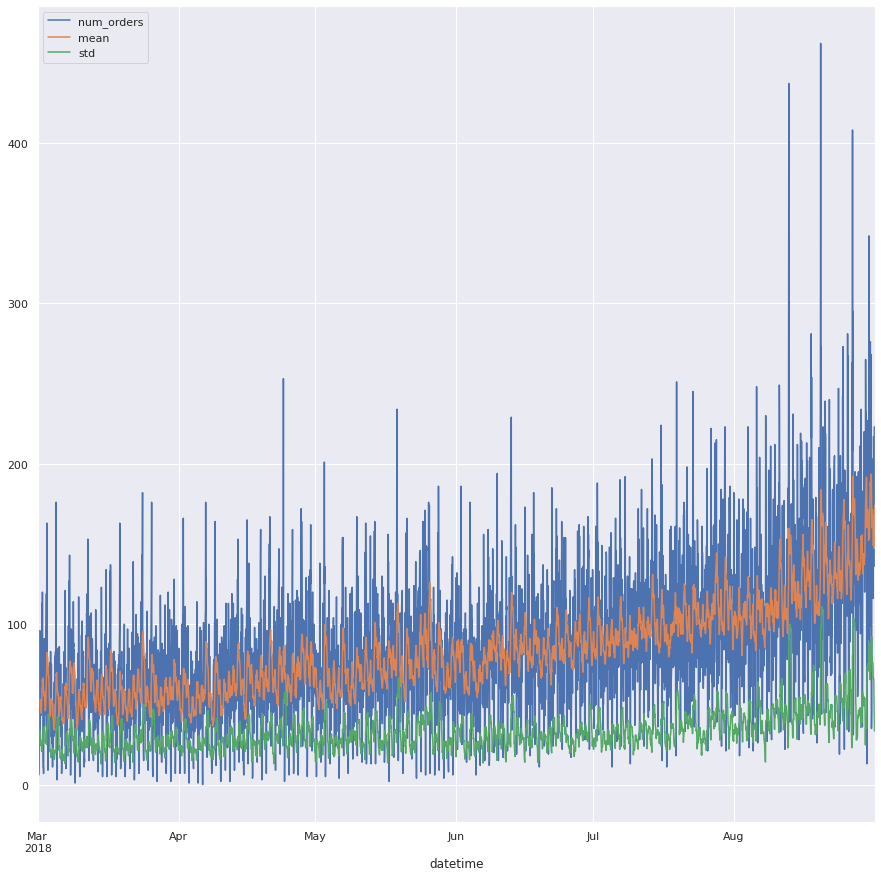

In [81]:
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot();

In [82]:
del df['mean']
del df['std']

Среднее значение увеличивается, по стандартному отклонению наблюдаем небольшое увеличение. Временной ряд - нестационарный. Замечаем большое количество пик на графике, как в меньшую, так и в большую сторону.  Следовательно, есть периоды повышенного и пониженного спроса на такси. Посмотрим на тренд, сезонность и остаток для числа заказов. 


Найдем тренд, сезонность и остаток для числа заказов. 

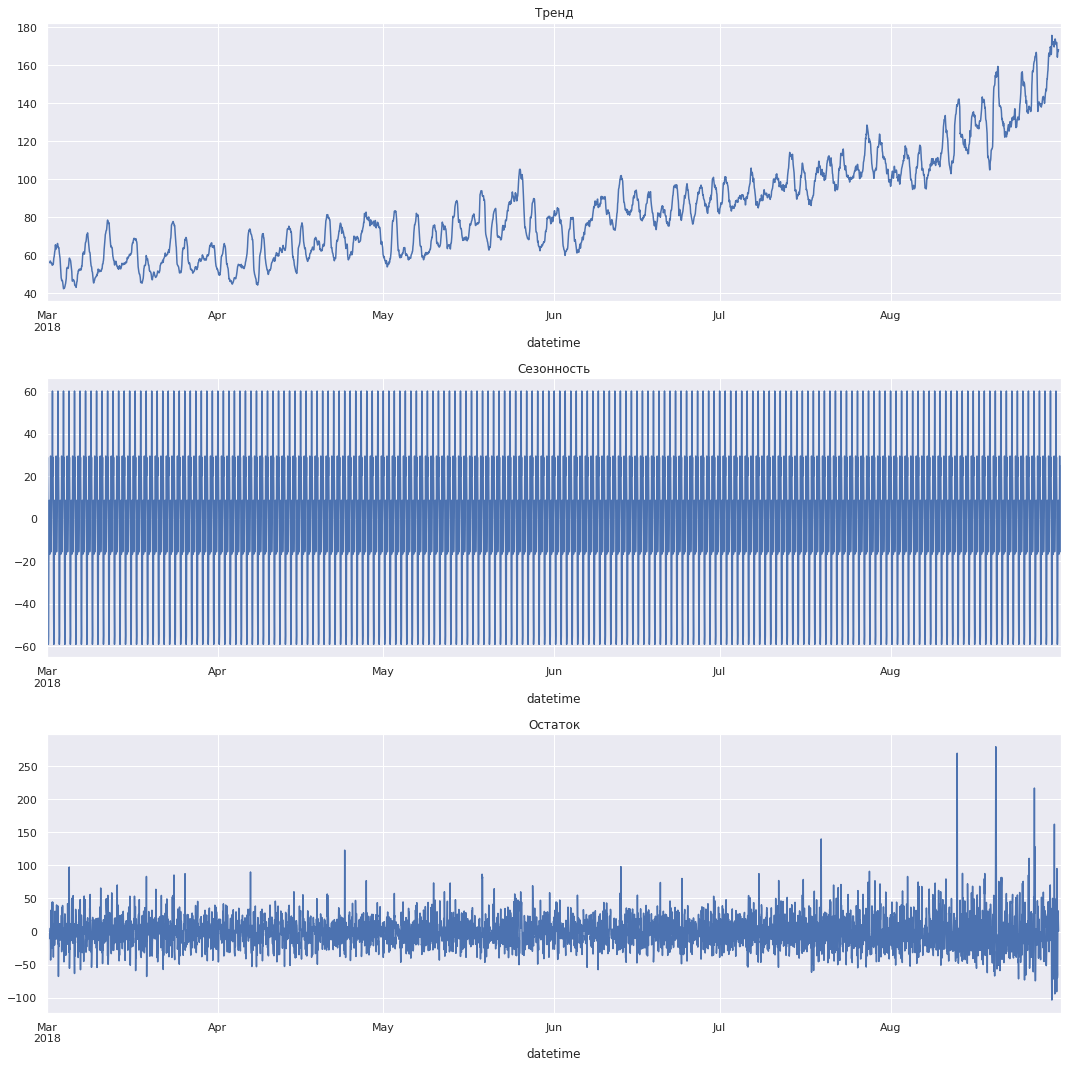

In [83]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')

plt.tight_layout()

Наблюдения для общего объема данных:
- Тренд: рост числа заказов от начала 2018-го года , почти линейный (степень при аргументе x в функции зависимости явно больше единицы)
- Сезонность: необходимо исследовать на меньшем интервале
- Остаток: заметен шум в данных, присутствуют пиковые значения количества заказов, как в меньшую так и в большую сторону

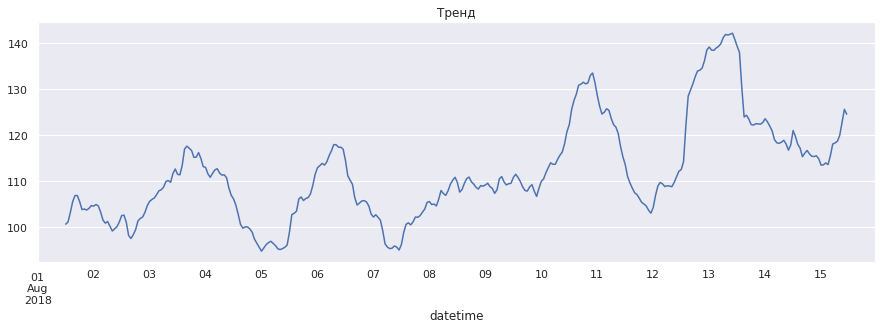

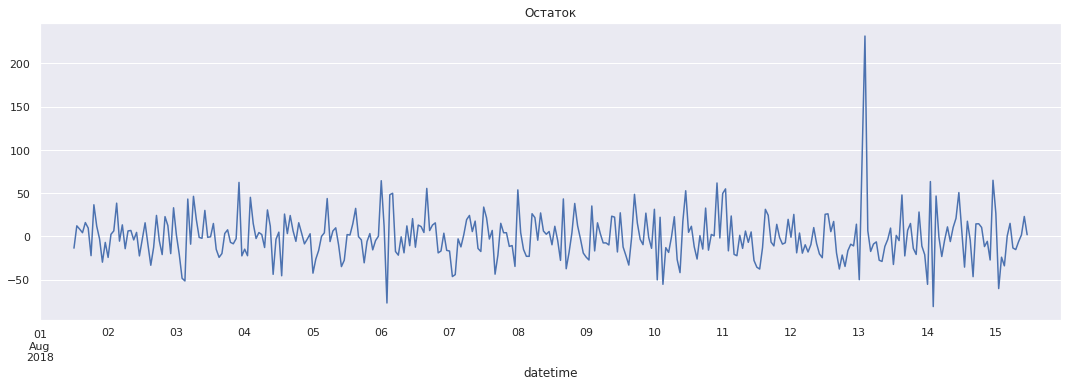

In [84]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-15'])

plt.figure(figsize=(15,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.figure(figsize=(15,15))
plt.subplot(311)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')

plt.tight_layout()

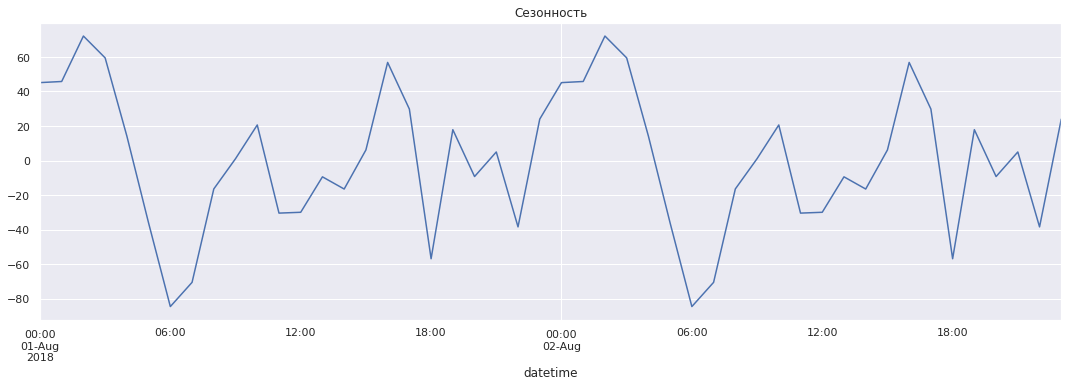

In [85]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-02'])

plt.figure(figsize=(15,15))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.tight_layout()

Наблюдения для первых дней августа 2018-го года:

- Сезонность: минимум заказов - на утренний период с 6 утра до 8 утра, максимум заказов - на ночной период с 0 часов до 2-3 часов. Возможно, это связано с закрытием других видов транспорта (метро, автобусы) в ночное время.
- Остаток: в определенные дни заметны выбросы. Возможно, это связано с праздником в эти дни или с каким-то событием. 

**Выводы по пункту 2:**

- Произвели ресемплинг данных по одному часу
- Среднее значение увеличивается, стандартное отклонение - наблюдаем небольшое увеличение. Временной ряд - нестационарный.
- Заметно большое количество пик на графике, направленных как в меньшую, так и в большую сторону. Скользящее среднее может помочь в прогнозировании. 

Наблюдения по тренду, сезонности и остатку :

- **Тренд**: рост числа заказов от начала 2018-го года , почти линейный (степень при аргументе x в функции зависимости явно больше единицы). В контексте пары дней - среднее увеличение близко к линейному.
- **Сезонность**: минимум заказов - на утренний период с 6 утра до 8 утра, максимум заказов - на ночной период с 0 часов до 2-3 часов. Возможно, это связано с недоступностью других видов транспорта (метро, автобусы) в ночное время.
- **Остаток**: заметен шум в данных, присутствуют пиковые значения количества заказов, как в меньшую так и в большую сторону. В определенные дни заметны значительные выбросы. Возможно, это связано с праздником в эти дни или с каким-то событием. 

## Обучение

Модели будем проверять на адекватность прогнозированием без обучения. Для этого будем предсказывать значение средним и предыдущим значением. 

In [86]:
train, test = train_test_split(df, shuffle = False, test_size=0.1)

Предсказание средним значением (mean)

In [87]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
rmse_mean_model = mean_squared_error(test['num_orders'], pred_mean)**0.5
print("RMSE = {0}".format(round(rmse_mean_model, 2)))

RMSE = 84.74


Предсказание последним значением (t-1)

In [88]:
pred_predictions = test.shift()
pred_predictions.iloc[0] = train.iloc[-1]
rmse_pred_model = mean_squared_error(test['num_orders'], pred_predictions)**0.5
print("RMSE = {0}".format(round(rmse_pred_model, 2)))

RMSE = 58.86


RMSE для модели с "отстающим предсказанием" (58.9) < RMSE для модели со "средним предсказанием" (84.7). То есть обе модели не проходят по требованию задания (RMSE < 48). 

Необходимо добавить временные признаки, обучить на них модели, подбирая оптимальные гиперпараметры, оценить модели на тестовой выборке и отобрать лучшую из них по RMSE, учитывая что RMSE должно получиться меньше 48.

Добавим временные признаки: 

- календарные - месяц, день недели, час 
- отстающие значения (i значений) - определение по предыдущим значениям, будет ли функция расти или уменьшаться
- скользящее среднее - задает общий тренд временного ряда

In [98]:
def make_features(data, max_lag, rolling_mean_size):
    
    #календарные

    #data['month'] = data.index.month
    #data['day'] = data.index.day -> уменьшает точность прогноза по rmse
    data['dayofweek'] = data.index.dayofweek
    #data['hour'] = data.index.hour -> уменьшает точность прогноза по rmse
    
    #отстающие
    for lag in range(1, max_lag+1):
        data['lag_{0}'.format(lag)] = data['num_orders'].shift(lag)
        
    #скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [99]:
class My_model:
    #self.optimizer:
    #1.создает модель с различными комбинациями гиперпараметров
    #2. обучает ее на данных с различными комбинациями временных признаков
    #3. тестирует ее на валидационной выборке
    #
    #
    '''
    
    self.optimizer(model_name, dataset):
    1. создает модель с различными комбинациями гиперпараметров
    2. обучает ее на данных с различными комбинациями временных признаков
    3. тестирует ее на валидационной выборке
    
    self.tester():
    Тестирует модель на тестовой выборке
    
    self.feature_importance():
    Находит "важность" каждого параметра для модели при предикции
    
    '''
    def __init__(self, model_name, dataset):
        
        self.dataset = dataset.copy()
        self.model_name = model_name
        self.optimizer(self.model_name, self.dataset)
        
        
    def optimizer(self, model_name, dataset):
    
        self.best_max_lag = 0
        self.best_rolling_mean_size = 0
        self.best_rmse = 48 #по условию должно быть ниже 48
        
        if (model_name=='Ridge'):
            self.best_alpha = 0
        elif (model_name=='LGBMRegressor'):
            self.best_n_estimators = 0
            self.best_depth = 0
    
        for lag in range(8, 50, 20):

            for rolling_mean_size in range(15, 70, 20):
                #при валидации: 
                #обучаем на первых 80%, валидируем на 10%
                #при тестировании: 
                #обучаем на 90% (80 с обучения + 10 с валидации), тестируем на последних 10%
                self.data = make_features(dataset, lag, rolling_mean_size)
                train_valid, test = train_test_split(self.data, shuffle=False, test_size=0.1)
                train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

                train = train.dropna()
                train_valid = train_valid.dropna()
                

                train_features = train.drop(['num_orders'], axis=1)
                train_target = train['num_orders']
                
                valid_features = valid.drop(['num_orders'], axis=1)
                valid_target = valid['num_orders']

                train_valid_features = train_valid.drop(['num_orders'], axis=1)
                train_valid_target = train_valid['num_orders']

                test_features = test.drop(['num_orders'], axis=1)
                test_target = test['num_orders']

                if (model_name=='LinearRegression'):
                    model = LinearRegression()
                    model.fit(train_features, train_target)
                    predictions = model.predict(valid_features)
                    rmse = mean_squared_error(valid_target, predictions) ** 0.5

                    if (rmse < self.best_rmse):
                        
                        self.best_rmse = rmse
                        self.best_max_lag = lag
                        self.best_rolling_mean_size = rolling_mean_size
                        
                        self.model = model
                        
                        self.train_valid_features = train_valid_features
                        self.train_valid_target = train_valid_target
                        
                        self.train_features = train_features
                        self.train_target = train_target
                        
                        self.valid_features = valid_features
                        self.valid_target = valid_target
                        
                        self.test_features = test_features
                        self.test_target = test_target
                        

                elif (model_name == 'Lasso'):

                    for alpha in np.arange(0, 2, 0.5):
                        
                        model = Lasso(alpha=alpha)
                        model.fit(train_features, train_target)
                        predictions = model.predict(valid_features)
                        rmse = mean_squared_error(valid_target, predictions) ** 0.5

                        if (rmse < self.best_rmse):
                            
                            self.best_rmse = rmse
                            self.best_max_lag = lag
                            self.best_rolling_mean_size = rolling_mean_size
                            
                            self.best_alpha = alpha
                            
                            self.model = model
                        
                            self.train_valid_features = train_valid_features
                            self.train_valid_target = train_valid_target

                            self.train_features = train_features
                            self.train_target = train_target

                            self.valid_features = valid_features
                            self.valid_target = valid_target

                            self.test_features = test_features
                            self.test_target = test_target
                        
                elif (model_name == 'Ridge'):

                    for alpha in np.arange(0, 2, 0.5):

                        model = Ridge(alpha=alpha)
                        model.fit(train_features, train_target)
                        predictions = model.predict(valid_features)
                        rmse = mean_squared_error(valid_target, predictions) ** 0.5

                        if (rmse < self.best_rmse):
                            
                            self.best_rmse = rmse
                            self.best_max_lag = lag
                            self.best_rolling_mean_size = rolling_mean_size
                            
                            self.best_alpha = alpha
                            
                            self.model = model
                        
                            self.train_valid_features = train_valid_features
                            self.train_valid_target = train_valid_target

                            self.train_features = train_features
                            self.train_target = train_target

                            self.valid_features = valid_features
                            self.valid_target = valid_target

                            self.test_features = test_features
                            self.test_target = test_target

                elif (model_name=='LGBMRegressor'):

                    for n_estimator in range(100, 400,200):
                        for depth in range(5,10,3):
                            model = LGBMRegressor(n_estimators=n_estimator, max_depth=depth)

                            model.fit(train_features, train_target)
                            predictions = model.predict(valid_features)
                            rmse = mean_squared_error(valid_target, predictions) ** 0.5

                            if (rmse < self.best_rmse):
                                
                                self.best_rmse = rmse
                                self.best_max_lag = lag
                                self.best_rolling_mean_size = rolling_mean_size
                                
                                self.best_n_estimators = n_estimator
                                self.best_depth = depth  
                                
                                self.model = model

                                self.train_valid_features = train_valid_features
                                self.train_valid_target = train_valid_target

                                self.train_features = train_features
                                self.train_target = train_target

                                self.valid_features = valid_features
                                self.valid_target = valid_target

                                self.test_features = test_features
                                self.test_target = test_target


        if (model_name=='LinearRegression'):
            print("Model: LinearRegression, RMSE: {0}, max_lag: {1}, rolling_mean_size: {2}".format(round(self.best_rmse, 2), self.best_max_lag, self.best_rolling_mean_size))
        
        elif (model_name == 'Lasso'):
            print("Model: Lasso, RMSE: {0}, max_lag: {1}, rolling_mean_size: {2}, alpha: {3}".format(round(self.best_rmse, 2), self.best_max_lag, self.best_rolling_mean_size, self.best_alpha))
        
        elif (model_name == 'Ridge'):
            print("Model: Ridge, RMSE: {0}, max_lag: {1}, rolling_mean_size: {2}, alpha: {3}".format(round(self.best_rmse, 2), self.best_max_lag, self.best_rolling_mean_size, self.best_alpha))

        elif (model_name=='LGBMRegressor'):
            print("Model: LGBMRegressor, RMSE: {0}, max_lag: {1}, rolling_mean_size: {2}, n_estimators: {3}, depth: {4}".format(round(self.best_rmse, 2), self.best_max_lag, self.best_rolling_mean_size, self.best_n_estimators, self.best_depth))
            
            
    def tester(self):
        

        self.model.fit(self.train_valid_features, self.train_valid_target)
        
        predictions = self.model.predict(self.test_features)
        rmse = mean_squared_error(self.test_target, predictions) ** 0.5
        
        prediction_df = pd.DataFrame(data=predictions, columns=['predictions'], index=self.test_target.index)
        comparison_table = pd.merge(self.test_target['2018-08-20':'2018-08-22'], prediction_df['2018-08-20':'2018-08-22'], left_index=True, right_index=True)
        comparison_table.plot()
        
        print("{0} model test result: RMSE: {1}".format(self.model_name, round(rmse, 2)))
        
    def feature_importance(self):
        
        if (self.model_name == "LinearRegression"):
            feature_importances = self.model.coef_
        elif (self.model_name == "LGBMRegressor"):   
            feature_importances = self.model.feature_importances_
            
        features = self.test_features.columns

        data = pd.DataFrame({'features' : features, 'feature_importances' : feature_importances})
        data.sort_values(by=['feature_importances'], inplace=True, ascending=False)
        data = data[:10]

        plt.figure(figsize=(15,15))

        sns.barplot(x=data['features'], y = data['feature_importances'])

        plt.title('Feature importances for {0} model'.format(self.model_name))
        plt.xlabel('features')
        plt.ylabel('feature_importances')
        
        


In [100]:
%%time

my_linear_regression = My_model('LinearRegression', df)

Model: LinearRegression, RMSE: 31.64, max_lag: 48, rolling_mean_size: 15
CPU times: user 687 ms, sys: 630 ms, total: 1.32 s
Wall time: 1.24 s


In [101]:
%%time

my_lasso_regression = My_model('Lasso', df)

Model: Lasso, RMSE: 31.64, max_lag: 48, rolling_mean_size: 55, alpha: 1.5
CPU times: user 7.97 s, sys: 9.25 s, total: 17.2 s
Wall time: 17.2 s


In [102]:
%%time

my_ridge_regression = My_model('Ridge', df)

Model: Ridge, RMSE: 31.64, max_lag: 48, rolling_mean_size: 35, alpha: 1.5
CPU times: user 1.62 s, sys: 1.92 s, total: 3.54 s
Wall time: 3.59 s


In [103]:
%%time

my_lgbm = My_model('LGBMRegressor', df)

Model: LGBMRegressor, RMSE: 30.86, max_lag: 48, rolling_mean_size: 15, n_estimators: 300, depth: 8
CPU times: user 50.8 s, sys: 636 ms, total: 51.4 s
Wall time: 52.3 s


In [104]:
final_table = pd.DataFrame([[round(my_linear_regression.best_rmse, 2), my_linear_regression.best_max_lag, my_linear_regression.best_rolling_mean_size, np.nan, np.nan, np.nan],
                           [round(my_lasso_regression.best_rmse, 2), my_lasso_regression.best_max_lag, my_lasso_regression.best_rolling_mean_size, my_lasso_regression.best_alpha, np.nan, np.nan],
                           [round(my_ridge_regression.best_rmse, 2), my_ridge_regression.best_max_lag, my_ridge_regression.best_rolling_mean_size, my_ridge_regression.best_alpha, np.nan, np.nan],
                           [round(my_lgbm.best_rmse, 2), my_lgbm.best_max_lag, my_lgbm.best_rolling_mean_size, np.nan, my_lgbm.best_n_estimators, my_lgbm.best_depth]],
                           columns=['rmse', 'max_lag', 'rolling_mean_size', 'alpha', 'n_estimators', 'depth'],
                           index=['LinearRegression', 'Lasso', 'Ridge', 'LightGBM'])
final_table

,rmse,max_lag,rolling_mean_size,alpha,n_estimators,depth
LinearRegression,31.64,48,15,NaN,NaN,NaN
Lasso,31.64,48,55,1.5,NaN,NaN
Ridge,31.64,48,35,1.5,NaN,NaN
LightGBM,30.86,48,15,NaN,300.0,8.0


**Выводы по пункту 3:**



- RMSE для модели с "отстающим предсказанием" равно 58.9, при этом оно меньше, чем RMSE для модели с "средним предсказанием" (84.7). То есть обе модели не проходят по требованию задания (RMSE < 48). 
- RMSE для линейной регрессии примерно равно RMSE для Lasso и Ridge, что говорит об отсутствии необходимости регуляризации в данном случае.
- Важно отметить, что все модели показывают хорошие результаты предсказания по RMSE на валидационной выборке.
- В качестве модели для тестирования принимаем lightGMB (как лучшую по RMSE = 30.86) с параметрами данных max_lag = 48, rolling_mean_size = 15 и гиперпараметрами модели n_estimators = 300, max_depth = 8.



## Тестирование

Модель lightGBM на валидационной выбоке показала лучший резултат по RMSE и подходит под условия задачи (RMSE < 48). Посмотрим на результат предсказания на тестовой выборке.

LGBMRegressor model test result: RMSE: 39.33
CPU times: user 3.22 s, sys: 40.8 ms, total: 3.26 s
Wall time: 3.31 s


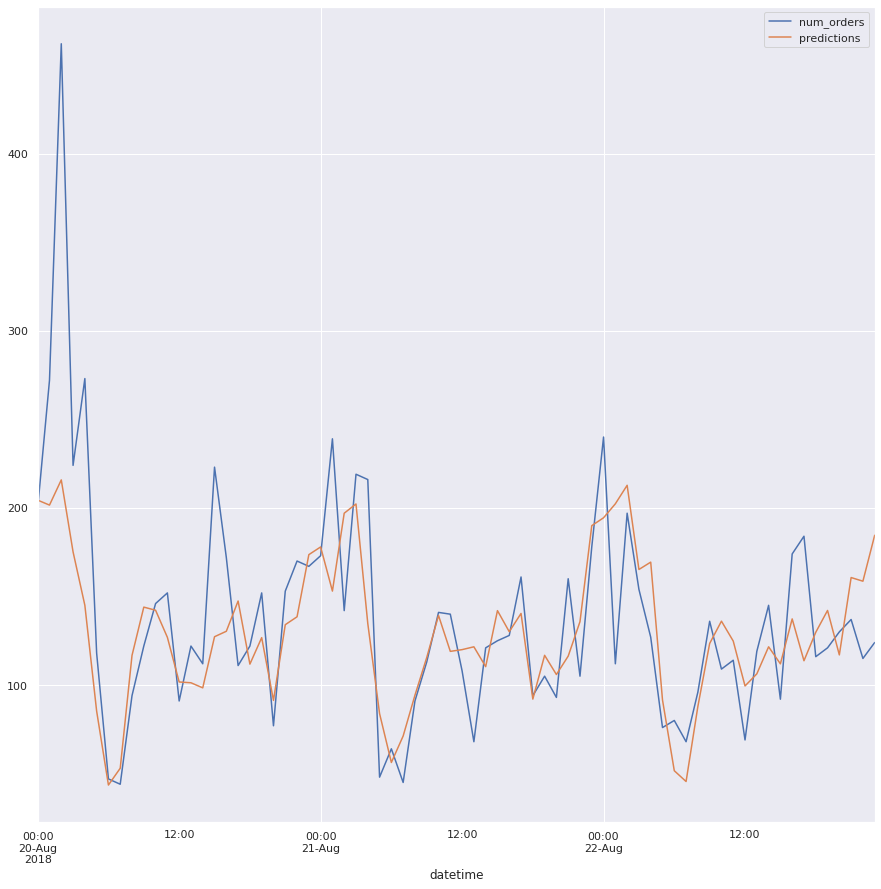

In [105]:
%%time

my_lgbm.tester()

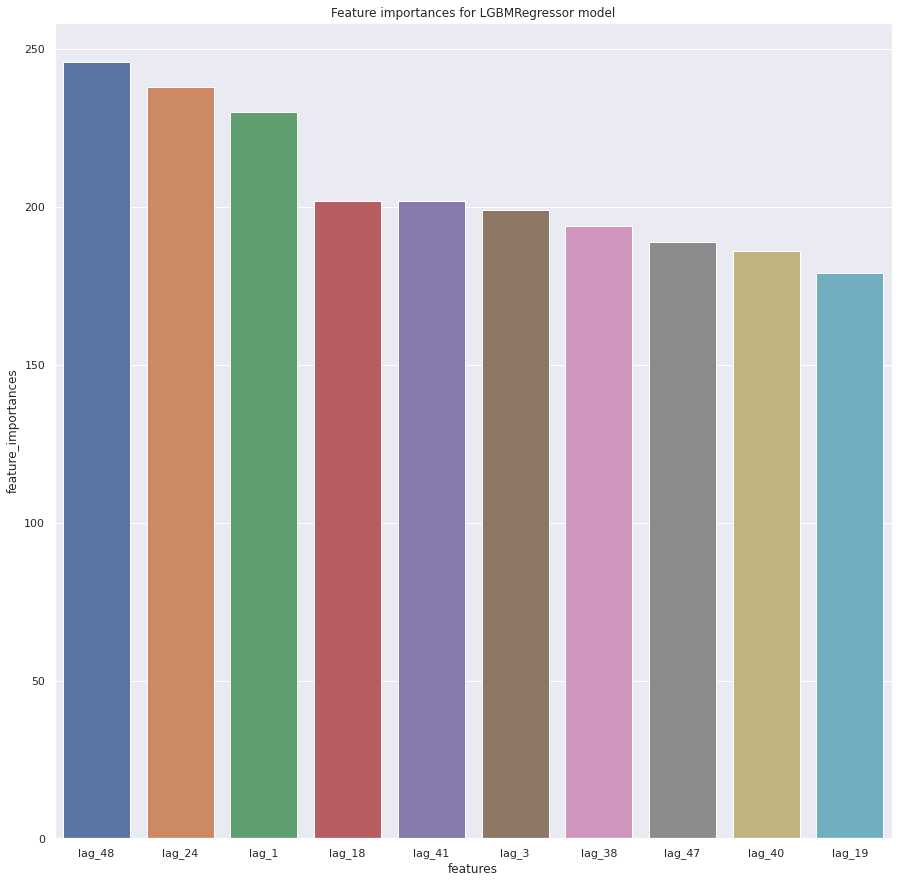

In [106]:
my_lgbm.feature_importance()

**Выводы по пункту 4:**

- **Итоговое RMSE на тестовой выбоке равно 39.33 < 48. Следовательно, модель справилась с условием задачи.**
- Топ-3 параметров, на основе которых модель делает предсказание (в порядке убывания значимости): **lag_48**, **lag_24**, **lag_1**
- **По оценке важности параметров необходимо интересно заметить, что модель в основном опирается на (1) подобные значения за предыдущие дни (lag_48 lag_24), и (2) на недавние значение (lag_1)**
- По графику количества заказов видно, что модель успешно предсказывает примерное число заказов, однако не способна распознать аномальные пиковые значение. Возможно, следует определить, в связи с чем происходят эти скачки в значениях и добавить еще параметр (например, был особенный день (чемпионат по футболу, который вызвал наплыв туристов)), который будет отражать пики.

# Общий вывод

**По осмотру данных**

- Провели общий осмотр данных, в датасете содержится 26496 наблюдений по единственному (целевому) признаку "число заказов". 
- Пропусков нет 
- Наблюдения расположены монотонно (временной индекс располагается в хронологическом порядке)
- Доля выбросов по целевому признаку 'Число заказов': 2.59%. Не будем удалять выбросы, их число невелико, но они будут полезны для будущего анализа.
- Данные скошены вправо (медиана 13 < среднее 14). Время начала данных: 2018-03-01 00:00:00, время конца данных: 2018-08-31 23:50:00. Минимальное число заказов:0, максимальное: 119

**По анализу данных**

- Произвели ресемплинг данных по одному часу
- Среднее значение увеличивается, стандартное отклонение - наблюдаем небольшое увеличение. Временной ряд - нестационарный.
- Заметно большое количество пик на графике, направленных как в меньшую, так и в большую сторону.

Наблюдения по тренду, сезонности и остатку :

- **Тренд**: рост числа заказов от начала 2018-го года , почти линейный (степень при аргументе x в функции зависимости явно больше единицы). В контексте пары дней - средний тренд увеличения близок к линейному.
- **Сезонность**: минимум заказов - на утренний период с 6 утра до 8 утра, максимум заказов - на ночной период с 0 часов до 2-3 часов. Возможно, это связано с недоступностью других видов транспорта (метро, автобусы) в ночное время.
- **Остаток**: заметен шум в данных, присутствуют пиковые значения количества заказов, как в меньшую так и в большую сторону. В определенные дни заметны значительные выбросы. Возможно, это связано с праздником в эти дни или с каким-то событием. 

**По обучению моделей**

- RMSE для модели с "отстающим предсказанием" равно 58.9, при этом оно меньше, чем RMSE для модели с "средним предсказанием" (84.7). То есть обе модели не проходят по требованию задания (RMSE < 48). 
- RMSE для линейной регрессии примерно равно RMSE для Lasso и Ridge, что говорит об отсутствии необходимости регуляризации в данном случае.
- Важно отметить, что все модели показывают хорошие результаты предсказания по RMSE на валидационной выборке.
- В качестве модели для тестирования принимаем lightGMB (как лучшую по RMSE = 30.86) с параметрами данных max_lag = 48, rolling_mean_size = 15 и гиперпараметрами модели n_estimators = 300, max_depth = 8.


**По тестированию**

- **Итоговое RMSE на тестовой выбоке равно 39.33 < 48. Следовательно, модель справилась с условием задачи.**
- Топ-3 параметров, на основе которых модель делает предсказание (в порядке убывания значимости): **lag_48**, **lag_24**, **lag_1**
- **По оценке важности параметров необходимо интересно заметить, что модель в основном опирается на (1) подобные значения за предыдущие дни (lag_48 lag_24), и (2) на недавние значение (lag_1)**
- По графику количества заказов видно, что модель успешно предсказывает примерное число заказов, однако не способна распознать аномальные пиковые значение. Возможно, следует определить, в связи с чем происходят эти скачки в значениях и добавить еще параметр (например, был особенный день (чемпионат по футболу, который вызвал наплыв туристов)), который будет отражать пики.
